# NP Predictive Analytics Assignment - Data Preparation
In this notebook we prepare the dataset for modeling

In [3]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.ma import polyfit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from data import dataset, dataprep

sns.set(style="whitegrid")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data
Load data from CSV files, merging math and portugese data as before.

In [20]:
# read data from CSV
col_dtypes = { col: "category" for col in dataset.cat_features + dataset.bin_features}
math_df = pd.read_csv(os.path.join("data", "Math.csv"), dtype=col_dtypes)
por_df = pd.read_csv(os.path.join("data", "Por.csv"), dtype=col_dtypes)

# merge data from math and portugese data
math_df["subject"] = "math"
por_df["subject"] = "portugese"
df = math_df.append(por_df)
df = df.reset_index()

## Feature Enginnering
Hand engineer features to produce better features

### Feature Extraction: Abstraction
To resolve the power law like distribution of `absences`, we apply `log()`

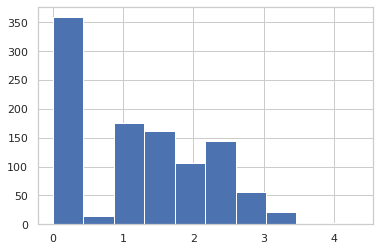

In [21]:
df["logAbsences"] = np.log1p(df["absences"])
df["logAbsences"].hist()

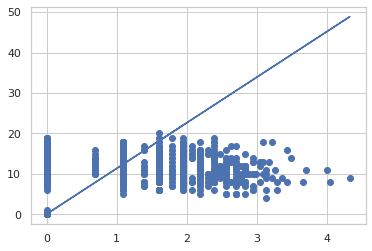

In [22]:
# scatterplot data
plt.scatter(df["logAbsences"], df[dataset.target_var])

# plot a linear regression line to visualise linear trends
b, m = polyfit(df["logAbsences"], df[dataset.target_var], 1)
line = m * df["logAbsences"] + b
plt.plot(df["logAbsences"], line)

Observations:
- The relationship between `logAbsences` and final grade appears to be nonlinear.

To resolve the nonlinear relationship between `logAbsences` and final grade, we can bucket `logAbsences` and convert into an ordinal variable:
- class 1 - $0 \le x \le 2$
- class 2 - $2 \lt x \le 2.5$
- class 3 - $2.5 \lt x \le 3.5$
- class 4 - $x \gt 3.5$

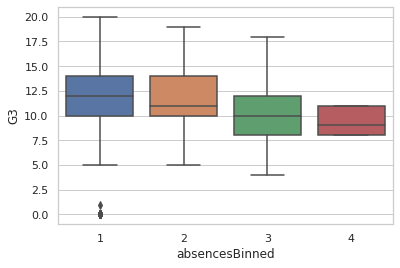

In [23]:
df["absencesBinned"] = pd.cut(df["logAbsences"], [0,  2, 2.5, 3.5, float("inf")],
                              labels=[1, 2, 3, 4], right=True, 
                              include_lowest=True).astype("int")
sns.boxplot(df["absencesBinned"], df[dataset.target_var])

### Feature Extraction: the Categorical Variable
As suggested by the dataset's research paper, we bucket the raw grades into bins (A,B,C,D,F) in an attempt address data imbalance:
- $16 \le A \le 20$
- $14 \le B \le 15$
- $12 \le C \le 13$
- $10 \le D \le 11$
- $0 \le F \le 9$

In [24]:
df["G3Binned"] = pd.cut(df[dataset.target_var], [0, 9, 11, 13, 15, 20], 
                        right=True, include_lowest=True,
                        labels=["F", "D", "C", "B", "A"]).astype("category")

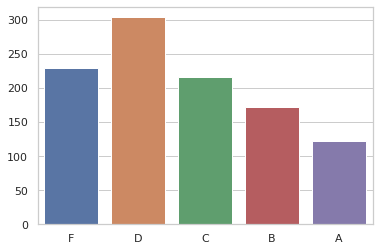

In [25]:
counts = df["G3Binned"].value_counts()
sns.barplot(counts.index, counts.values)

Observations:
- Binning has resolved some data imbalance.
- Resampling can be used to further combat data balance.

### Feature Combinations
Engineer new features by combining existing features

- `alc` combines alchol consumption over the entire week, giving more weight to weekday alchol consumption.
- `gooutAlc` combines alcohol consumption with going out with friends
- `freeAlc` combines alchohol consumption with freetie
- `goFriendAlc` combines alchol consumption with going out 

<BarContainer object of 7 artists>

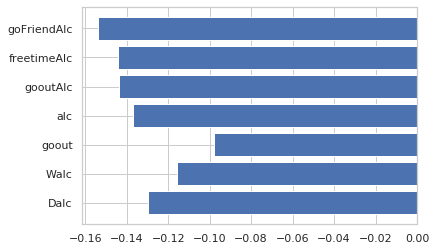

In [26]:
df["alc"] = (2 * df["Dalc"] + df["Walc"])
df["freetimeAlc"] = df["alc"] * df["freetime"]
df["gooutAlc"] = df["alc"] * df["goout"]
df["goFriendAlc"] = df["goout"] * df["freetime"] * df["alc"]

correlations = df.loc[:, ["Dalc", "Walc", "goout", "alc", 
                          "gooutAlc", "freetimeAlc", "goFriendAlc"]
                     ].corrwith(df["G3"])
plt.barh(correlations.index, correlations)

- `failSqrt` square root of failures gives a slightly higher correlation. 
Perhaps due to the relation betwen `failures` and `G3` being nonlinear.

<BarContainer object of 2 artists>

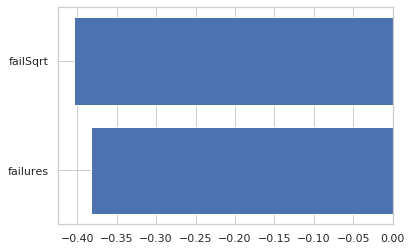

In [32]:
df["failSqrt"] = np.sqrt(df["failures"]) 

correlations = df.loc[:, ["failures", "failSqrt"]].corrwith(df["G3"])
plt.barh(correlations.index, correlations)

- `Pedu` combines the education levels of both mother and father
- `Psup` parent support: family relations with size of family
- `Pedusup` combines parent support and parent education level


<BarContainer object of 6 artists>

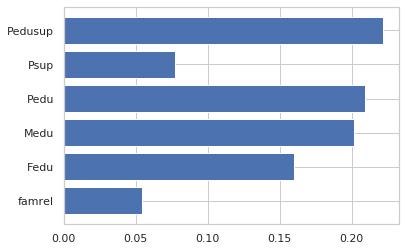

In [48]:
df["Pedu"] = df["Fedu"] + df["Medu"] ** 3
df["Psup"] = df["famrel"] ** 2 * df["famsize"].cat.codes
df["Pedusup"] = df["Pedu"] + df["Psup"]


correlations = df.loc[:, ["famrel", "Fedu", "Medu", "Pedu", 
                          "Psup", "Pedusup"]].corrwith(df["G3"])
plt.barh(correlations.index, correlations)

## Data Preparation
In this section, we preprocess the data into a form suitable for modeling

## Inputs and Outputs
Extract & separate the target output variable from the rest of the data
- final scores `G3` for regression task
- final grades `G3Binnned` for classification task


In [49]:
final_scores = df[dataprep.reg_target_var]
final_grades = df[dataprep.classify_target_var]
inputs_df = df.drop(columns=[dataprep.reg_target_var, 
                             dataprep.classify_target_var])

Encode categories into numeric integers

In [50]:
grade_mapping = list(enumerate(final_grades.cat.categories))
final_grades = final_grades.cat.codes
grade_mapping

[(0, 'F'), (1, 'D'), (2, 'C'), (3, 'B'), (4, 'A')]

## Split Dataset
Set aside hold out test set for later cross validation
- use stratified sampling by final grade `G3Binned` to select examples for test set

> Since dataset is relatively small, we stratify the sample by the 
> final grade to limit the error introduced by sampling bias

In [52]:
# generate randomly split indexes that define split 
train_idxs, test_idxs = train_test_split(list(range(len(df))), 
                                         shuffle=True,
                                         stratify=final_grades,
                                         test_size=200)

# split dataset based on indexes
train_in_df, test_in_df = inputs_df.iloc[train_idxs], inputs_df.iloc[test_idxs]
train_scores, test_scores = final_scores[train_idxs], final_scores[test_idxs]
train_grades, test_grades = final_grades[train_idxs], final_grades[test_idxs]

## Build Data Pipeline
Build a Data Pipeline to preprocess the dataset:
1. Transform features into form suitable for modeling
    - numeric features - feature scale using Z-score transform
    - categorical features - feature extraction by one hot encoding
    - binary features - feature extraction by ordinal encoding
   

In [58]:
df_transformer = ColumnTransformer([
        ("cat_pipeline", OneHotEncoder(), dataprep.cat_features),
        ("bin_pipeline", OrdinalEncoder(), dataprep.bin_features),
        ("num_pipeline", StandardScaler(), dataprep.num_features)]
)

In [59]:
pipeline = Pipeline([
    ("transformer", df_transformer),
])

## Prepare Data
Use the built data pipelines to prepare dataset for modeling

In [61]:
pipeline.fit(train_in_df)
train_data = pipeline.transform(train_in_df)
test_data = pipeline.transform(test_in_df)

### Data Imbalance
Perform random duplication of data example with a minority classes/label final grade to combat data imbalance.

> This is important as the data imbalance would cause the classifer
> to be biased towards the majority class/label instead of trying to
> predict all classes/labels accurately.

In [62]:
resampler = RandomOverSampler()
rs_train_data, rs_train_grades = resampler.fit_resample(train_data, train_grades)

## Commit Data
Commit prepared data and objects used to prepare data

In [63]:
np.savez_compressed(os.path.join("build", "dataprep.npz"),
                    # test data
                    test_data=test_data,
                    test_scores=test_scores,
                    test_grades=test_grades,
                    # regression training data
                    reg_train_data=train_data,
                    reg_train_scores=train_scores,
                    # classification data
                    classify_train_data=rs_train_data,
                    classify_train_grades=rs_train_grades,
                    train_idxs=train_idxs, test_idxs=test_idxs)

In [64]:
joblib.dump({
    "pipeline": pipeline,
    "grade_mapping": grade_mapping
}, os.path.join("build","dataprep.joblib"))

['build/dataprep.joblib']